This code 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from pycine.raw import read_frames
from scipy import signal
import skimage
from skimage.filters import threshold_otsu, sobel, try_all_threshold, threshold_local, threshold_triangle, threshold_minimum

import cv2 as cv
import re
import glob



def find_files(pattern):
    """Use regex to locate desired files
    Returns list of file paths.
    """
    cine_files = glob.glob(r"D:\Raw_DPSP-Data/*/*.cine")
    pattern = re.compile(pattern)
    matches = [file for file in cine_files if pattern.search(file) is not None]
    
    return matches


def load_cine(file, start_frame=0, n_frames=1):
    """Transforms cine file into np.array."""
    cine_file = file
    start_frame = start_frame
    count = n_frames
    raw_images, setup, bpp = read_frames(cine_file, start_frame=start_frame, count=count)
    images = np.array([next(raw_images) for _ in range(n_frames)],dtype=np.float32)
    
    return images


def array_norm(image):

    im = image.copy()
    im_max = im.max()
    im_min = im.min()
    im_norm = (im-im_min)/(im_max-im_min)

    return im_norm



# functions used for automating ptaps assignment and creating an array surrounding each one to determine lumo 

def thresh_image(im_norm, thresh=0.05):
    """sets all pixels lower than threshold to 1 and everything else to zero.
    """

    im_norm = im_norm.copy()
    im_norm_max = im_norm.max()
    im_norm[im_norm > thresh] = im_norm_max*2 # arb number used as intermediate stage
    im_norm[im_norm <= thresh] = 1
    im_norm[im_norm == im_norm_max*2] = 0
    
    return im_norm


def process_image(img_raw):
    """get image ready for cv2 circle finder."""

    img = array_norm(img_raw)

    # create multiple images at different thresholds then compile into one image
    im_thresh_lst = []
    for i in np.arange(0.005,0.1,0.005):
        im_thresh = thresh_image(img, thresh=i)
        im_thresh_lst.append(im_thresh)

    labs = np.sum(im_thresh_lst, axis=0)

    # blur out noise
    img = skimage.filters.gaussian(labs, sigma=2, )
    img = array_norm(img)

    # cv takes 8 bit image
    img = img*100 
    img = img.astype(np.uint8) 
    
    return img


def find_distance(coords):
    """Calculate distance between two sets of coordinates
    input: list of n tuples of shape (2,)
    output: matrix nxn of distances"""
    if not isinstance(coords, np.ndarray):
        coords = np.array(coords)
    
    x, y = coords.T
    x = x[:, np.newaxis]
    y = y[:, np.newaxis]
    distance = np.sqrt((x-x.T)**2 + (y-y.T)**2)
    return distance


## Finding ptap locations at beta 0 no-store config and the relative distance between each one.

The following code takes the raw image, processes it to make circular features more visible, and then searches for circular features. 

Circular features for this particular image are manually labelled as their respective pressure tap and put into a dataset which includes the distance from each circular feature to all others. This will be used as a "finger print" for each pressure tap so that the pressure taps may be automatically labelled for other images.

The same logic used in the cell below is then applied to the other two wind tunnel test configurations to allow complete automation in the labelling of all other wind tunnel tests.

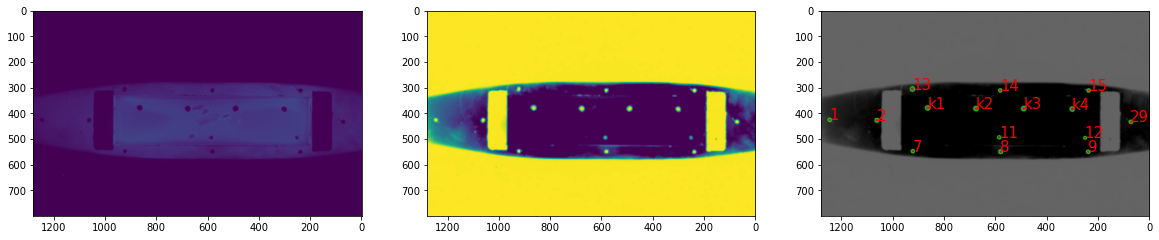

,x,y,r,ptap,1,2,13,7,k1,k2,11,14,8,k3,k4,12,9,15,29
0,1246,426,7,1,0.000000,184.010869,343.633526,346.208030,384.759665,571.695723,663.493783,673.715073,677.445201,757.279341,944.933860,996.461740,1013.613339,1014.425946,1172.027303
1,1062,428,8,2,184.010869,0.000000,184.195548,184.390889,203.735122,388.731270,480.553847,493.817780,497.200161,573.846669,761.272619,812.849310,831.004212,832.124991,988.018218
2,924,306,9,13,343.633526,184.195548,0.000000,242.008264,95.268043,259.383885,386.766079,342.052628,421.748740,440.604131,626.871598,698.343755,726.217598,686.026239,859.583620


,x,y,r,ptap,1,2,13,7,k1,k2,11,14,8,k3,k4,12,9,15,29,configuration
0,1246,426,7,1,0.000000,184.010869,343.633526,346.208030,384.759665,571.695723,663.493783,673.715073,677.445201,757.279341,944.933860,996.461740,1013.613339,1014.425946,1172.027303,no_store
1,1062,428,8,2,184.010869,0.000000,184.195548,184.390889,203.735122,388.731270,480.553847,493.817780,497.200161,573.846669,761.272619,812.849310,831.004212,832.124991,988.018218,no_store
2,924,306,9,13,343.633526,184.195548,0.000000,242.008264,95.268043,259.383885,386.766079,342.052628,421.748740,440.604131,626.871598,698.343755,726.217598,686.026239,859.583620,no_store


In [37]:
pat=r"D:\\Raw_DPSP-Data\\62070-DPSP-Empty-Bay-doors-off-sawtooth-LE-TE-Beta0\\MBH009_62070_M_000_Beta_0_CineF24.cine"
m0 = find_files(pat)
file = m0[0]
ims = load_cine(file)
img_raw = ims[0,:,:]
img = process_image(img_raw)
cimg = cv.cvtColor(img,cv.COLOR_GRAY2BGR)

circles = cv.HoughCircles(img,cv.HOUGH_GRADIENT,1,50,
                            param1=25,param2=15, minRadius=0,maxRadius=10)
if circles is not None:
    circles = np.uint16(np.around(circles[0]))
    for i in circles:
        # draw the outer circle
        cv.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
        # draw the center of the circle
        cv.circle(cimg,(i[0],i[1]),2,(255,0,0),3)

# side-by-side plots of labelling process
kwargs = {'aspect':'equal'}
fig, axs = plt.subplots(1,3, figsize=(20,10))
axs[0].imshow(img_raw, **kwargs)
axs[1].imshow(img, **kwargs)
axs[2].imshow(cimg, **kwargs)

# create dataframe containing labelled ptap coordinates and radii
df = pd.DataFrame(circles, columns=['x', 'y', 'r'])
df = df.sort_values('x', ascending=False).reset_index(drop=True)
ptaps = [1, 2, 13, 7, 'k1', 'k2', 11, 14, 8, 'k3', 'k4', 12, 9, 15, 29]
df['ptap'] = ptaps


# annotate plot with labelled ptaps
circle_coords = [*zip(df['x'], df['y'])]
for i, coord in enumerate(circle_coords):
    axs[2].text(coord[0], coord[1], df.ptap[i], c='r', size=15)

for i in range(3):    
    axs[i].invert_xaxis()
    
    
plt.show()


distance_mat = find_distance(circle_coords)        
dist_df = pd.DataFrame(np.array(distance_mat).reshape(15,15))
dist_df.columns = df.ptap



ptap_df = df.join(dist_df)


no_store_ptap_df = ptap_df.copy()
no_store_ptap_df['configuration'] = 'no_store'

display(no_store_ptap_df.head(3))


## Finding ptap locations at beta 0 store in bay config and distance between each one.


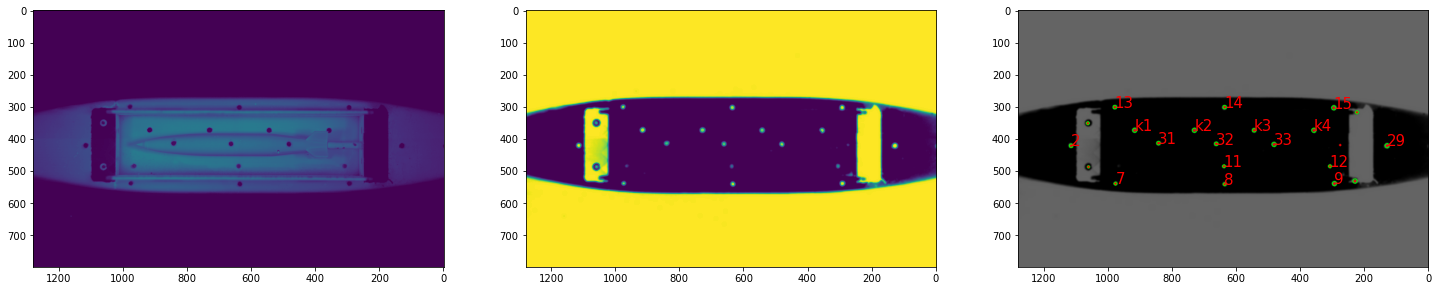

,x,y,r,ptap,2,13,7,k1,31,k2,...,14,8,k3,33,k4,12,15,9,29,configuration
0,1114,422,6,2,0.000000,181.372545,181.570923,203.735122,272.117622,386.988372,...,492.832629,492.832629,572.017482,632.012658,757.522277,808.536950,826.467180,828.446739,984.000000,store_in
1,978,302,6,13,181.372545,0.000000,238.008403,95.015788,176.181724,258.240198,...,342.000000,417.808569,439.931813,509.383942,624.166644,694.806448,682.002933,724.223722,856.448481,store_in
2,976,540,5,7,181.570923,238.008403,0.000000,176.510623,183.934771,296.769271,...,415.022891,340.005882,462.795851,508.841822,639.906243,670.179081,719.788858,682.000000,854.189674,store_in


In [25]:
# pat=r"D:\\Raw_DPSP-Data\\62070-DPSP-Empty-Bay-doors-off-sawtooth-LE-TE-Beta0\\MBH009_62070_M_000_Beta_0_CineF24.cine"
pat=r"D:\Raw_DPSP-Data\62120-DPSP-Store-in-doors-on-no-LE-TE-Beta0\MBH009-62120_M-000-Beta-0_CineF1.cine"
pat=r"D:\Raw_DPSP-Data\62130-DPSP-Store-in-doors-on-sawtooth-LE-TE-Beta0\MBH009_62130_M-000-Beta-0_CineF5.cine"
# m0 = find_files(pat)
# file = m0[0]
ims = load_cine(pat)
img_raw = ims[0,:,:]
img = process_image(img_raw)
cimg = cv.cvtColor(img,cv.COLOR_GRAY2BGR)

circles = cv.HoughCircles(img,cv.HOUGH_GRADIENT,1,50,
                            param1=25,param2=10, minRadius=0,maxRadius=10)
if circles is not None:
    circles = np.uint16(np.around(circles[0]))
    for i in circles:
        # draw the outer circle
        cv.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
        # draw the center of the circle
        cv.circle(cimg,(i[0],i[1]),2,(255,0,0),3)

# side-by-side plots of labelling process
kwargs = {'aspect':'equal'}
fig, axs = plt.subplots(1,3, figsize=(25,10))
axs[0].imshow(img_raw, **kwargs)
axs[1].imshow(img, **kwargs)
axs[2].imshow(cimg, **kwargs)


# # create dataframe containing labelled ptap coordinates and radii
df = pd.DataFrame(circles, columns=['x', 'y', 'r'])
df = df.sort_values('x', ascending=False).reset_index(drop=True)

# # annotate plot with labelled ptaps
circle_coords = [*zip(df['x'], df['y'])]



ptaps = {0:2, 3:13, 4:7, 5:'k1', 6:31, 7:'k2', 8:32, 9:11, 10:14, 11:8, 12:'k3', 13:33, 14:'k4', 15:12, 16:15, 17:9, 21:29} # Matching unlabelled numbered circles to ptap labels
ptaps_df = pd.DataFrame.from_dict(ptaps, orient='index')
    

df=  df.join(ptaps_df)
df.rename(columns={0:'ptap'}, inplace=True)

distance_mat = find_distance(circle_coords)

        
dist_df = pd.DataFrame(np.array(distance_mat).reshape(df.shape[0],df.shape[0]))
dist_df.columns = df.ptap



# this is the dataset that will enable ptap identification in other no store configurations.
# contains physical info about a ptap and its relative distance from others. 
ptap_df = df.join(dist_df)
ptap_df.dropna(inplace=True)
ptap_df = ptap_df.loc[:, ptap_df.columns.notna()]
ptap_df.reset_index(inplace=True, drop=True) # nb: important to reset index when carrying out slicing as slicing is based on index



circle_coords = [*zip(ptap_df['x'], ptap_df['y'])]

for i in range(ptap_df.shape[0]):
    axs[2].text(ptap_df.x[i], ptap_df.y[i], ptap_df.ptap[i], c='r', size=15)
    
    
for i in range(3):    
    axs[i].invert_xaxis()

plt.show()  



store_in_ptap_df = ptap_df.copy()
store_in_ptap_df['configuration'] = 'store_in'

display(store_in_ptap_df.head(3))


## Finding ptap locations at beta 0 store out of bay config and distance between each one.

This works only with configurations where the store is out of focus.

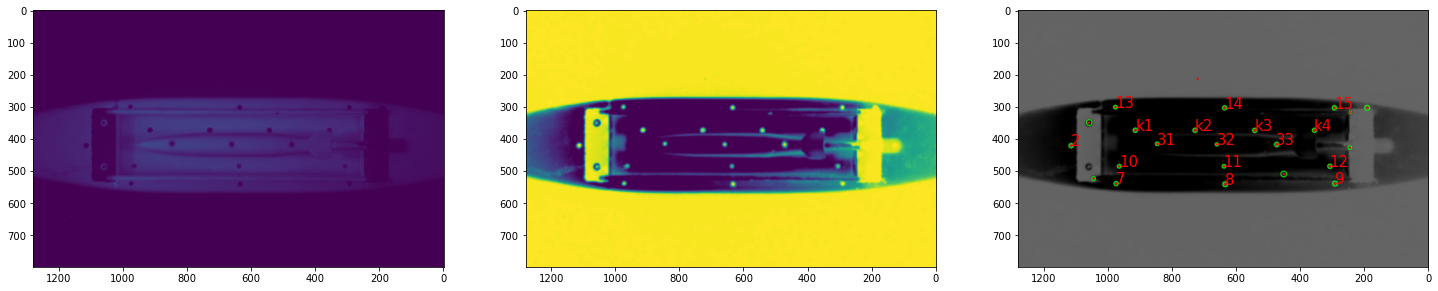

,x,y,r,ptap,2,13,7,10,k1,31,...,11,14,8,k3,33,k4,12,15,9,configuration
0,1114,422,7,2,0.000000,182.877008,183.095603,163.082801,205.679362,268.067156,...,480.283250,492.349469,494.772675,574.010453,640.012500,759.518268,808.536950,828.446739,830.426396,store_out
1,976,302,6,13,182.877008,0.000000,238.008403,184.390889,95.015788,172.904598,...,384.837628,340.005882,417.808569,439.931813,515.228105,624.166644,692.878056,682.002933,724.223722,store_out
2,974,540,7,7,183.095603,238.008403,0.000000,54.918121,176.510623,178.213355,...,340.311622,412.237795,340.005882,462.795851,514.668826,639.906243,668.185603,719.788858,682.000000,store_out


,2,13,7,10,k1,31,k2,32,11,14,8,k3,33,k4,12,15,9
0,0.000000,182.877008,183.095603,163.082801,205.679362,268.067156,388.973007,454.017621,480.283250,492.349469,494.772675,574.010453,640.012500,759.518268,808.536950,828.446739,830.426396
1,182.877008,0.000000,238.008403,184.390889,95.015788,172.904598,258.240198,336.618478,384.837628,340.005882,417.808569,439.931813,515.228105,624.166644,692.878056,682.002933,724.223722
2,183.095603,238.008403,0.000000,54.918121,176.510623,178.213355,296.769271,336.867927,340.311622,412.237795,340.005882,462.795851,514.668826,639.906243,668.185603,719.788858,682.000000
3,163.082801,184.390889,54.918121,0.000000,122.653985,137.200583,261.227870,311.512440,326.000000,375.110650,334.717792,436.609665,494.695866,618.229731,656.000000,694.279483,674.166152
4,205.679362,95.015788,176.510623,122.653985,0.000000,79.924965,186.000000,257.782854,297.859027,286.677519,326.533306,372.000000,442.194527,558.000000,616.262931,623.939100,643.770145
5,268.067156,172.904598,178.213355,137.200583,79.924965,0.000000,125.251746,186.010752,219.462981,238.000000,246.617112,306.887602,372.005376,491.796706,542.534792,563.247725,567.707671
6,388.973007,258.240198,296.769271,261.227870,186.000000,125.251746,0.000000,80.993827,143.680200,115.602768,192.509740,186.000000,257.782854,372.000000,434.676891,439.608917,466.531885
7,454.017621,336.618478,336.867927,311.512440,257.782854,186.010752,80.993827,0.000000,71.470274,116.498927,126.696488,125.936492,186.000000,307.167707,358.508019,383.343188,387.695757
8,480.283250,384.837628,340.311622,326.000000,297.859027,219.462981,143.680200,71.470274,0.000000,182.010989,56.142675,147.512711,177.538728,303.427092,330.000000,389.178622,350.188521
9,492.349469,340.005882,412.237795,375.110650,286.677519,238.000000,115.602768,116.498927,182.010989,0.000000,238.008403,117.200683,198.090888,288.617394,375.110650,342.000000,417.171428


In [46]:
file=r"D:\Raw_DPSP-Data\62160-DPSP-Store-out-doors-on-sawtooth-LE-TE-Beta0\MBH009_62160_M-000-Beta_00_CineF22.cine"

ims = load_cine(file)
img_raw = ims[0,:,:]
img = process_image(img_raw)
cimg = cv.cvtColor(img,cv.COLOR_GRAY2BGR)

circles = cv.HoughCircles(img,cv.HOUGH_GRADIENT,1,50,
                            param1=25,param2=10, minRadius=0,maxRadius=10)
if circles is not None:
    circles = np.uint16(np.around(circles[0]))
    for i in circles:
        # draw the outer circle
        cv.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
        # draw the center of the circle
        cv.circle(cimg,(i[0],i[1]),2,(255,0,0),3)

# side-by-side plots of labelling process
kwargs = {'aspect':'equal'}
fig, axs = plt.subplots(1,3, figsize=(25,10))
axs[0].imshow(img_raw, **kwargs)
axs[1].imshow(img, **kwargs)
axs[2].imshow(cimg, **kwargs)


# # create dataframe containing labelled ptap coordinates and radii
df = pd.DataFrame(circles, columns=['x', 'y', 'r'])
df = df.sort_values('x', ascending=False).reset_index(drop=True)

# # annotate plot with labelled ptaps
circle_coords = [*zip(df['x'], df['y'])]



ptaps = {0:2, 3:13, 4:7, 5:10, 6:'k1', 7:31, 8:'k2', 10:32, 11:11, 12:14, 13:8, 14:'k3', 15:33, 17:'k4', 18:12, 19:15, 20:9}
ptaps_df = pd.DataFrame.from_dict(ptaps, orient='index')
    

df=  df.join(ptaps_df)
df.rename(columns={0:'ptap'}, inplace=True)

distance_mat = find_distance(circle_coords)

        
dist_df = pd.DataFrame(np.array(distance_mat).reshape(df.shape[0],df.shape[0]))
dist_df.columns = df.ptap



# this is the dataset that will enable ptap identification in other no store configurations.
# contains physical info about a ptap and its relative distance from others. 
ptap_df = df.join(dist_df)
ptap_df.dropna(inplace=True)
ptap_df = ptap_df.loc[:, ptap_df.columns.notna()]
ptap_df.reset_index(inplace=True, drop=True) # nb: important to reset index when carrying out slicing as slicing is based on index



circle_coords = [*zip(ptap_df['x'], ptap_df['y'])]

for i in range(ptap_df.shape[0]):
    axs[2].text(ptap_df.x[i], ptap_df.y[i], ptap_df.ptap[i], c='r', size=15)
    
    
for i in range(3):    
    axs[i].invert_xaxis()

plt.show()  




store_out_ptap_df = ptap_df.copy()
store_out_ptap_df['configuration'] = 'store_out'

display(store_out_ptap_df.head(3))
only_ptap_columns = ~store_out_ptap_df.columns.isin(['x', 'y', 'r', 'ptap', 'configuration'])
store_out_ptap_df.loc[:,only_ptap_columns]


##### this does not work for store out config when store is in focus.

All lablled pressure tap data are stored into a single dataframe for convenience. 

A function to detect an image configuration is employed to filter the dataset and give the appropriate pressure tap data.

In [48]:


ptap_df = pd.concat((no_store_ptap_df, store_in_ptap_df, store_out_ptap_df))

def get_defined_ptaps(path):
    if re.search("Empty-Bay", file) is not None:
        file_ptap_df = ptap_df.loc[ptap_df['configuration']=='no_store']
    elif re.search("Store-in", file) is not None:
        file_ptap_df = ptap_df.loc[ptap_df['configuration']=='store_in']
    elif re.search("Store-out", file) is not None:
        file_ptap_df = ptap_df.loc[ptap_df['configuration']=='store_out']
        
    return file_ptap_df

In [58]:
# Demonstration of previous cell code.

path=r"D:\\Raw_DPSP-Data\\62070-DPSP-Empty-Bay-doors-off-sawtooth-LE-TE-Beta0\\MBH009_62070_M_000_Beta_0_CineF24.cine" 

df = get_defined_ptaps(path)

only_ptap_columns = ~df.columns.isin(['x', 'y', 'r', 'ptap', 'configuration']) # Showing only the distances from a pressure tap (a record) to every other (each feature).
df = df.loc[:,only_ptap_columns]



display(df.dropna(axis=1))

,2,13,7,k1,k2,11,14,8,k3,k4,12,9,15,31,32,33,10
0,0.000000,182.877008,183.095603,205.679362,388.973007,480.283250,492.349469,494.772675,574.010453,759.518268,808.536950,830.426396,828.446739,268.067156,454.017621,640.012500,163.082801
1,182.877008,0.000000,238.008403,95.015788,258.240198,384.837628,340.005882,417.808569,439.931813,624.166644,692.878056,724.223722,682.002933,172.904598,336.618478,515.228105,184.390889
2,183.095603,238.008403,0.000000,176.510623,296.769271,340.311622,412.237795,340.005882,462.795851,639.906243,668.185603,682.000000,719.788858,178.213355,336.867927,514.668826,54.918121
3,163.082801,184.390889,54.918121,122.653985,261.227870,326.000000,375.110650,334.717792,436.609665,618.229731,656.000000,674.166152,694.279483,137.200583,311.512440,494.695866,0.000000
4,205.679362,95.015788,176.510623,0.000000,186.000000,297.859027,286.677519,326.533306,372.000000,558.000000,616.262931,643.770145,623.939100,79.924965,257.782854,442.194527,122.653985
5,268.067156,172.904598,178.213355,79.924965,125.251746,219.462981,238.000000,246.617112,306.887602,491.796706,542.534792,567.707671,563.247725,0.000000,186.010752,372.005376,137.200583
6,388.973007,258.240198,296.769271,186.000000,0.000000,143.680200,115.602768,192.509740,186.000000,372.000000,434.676891,466.531885,439.608917,125.251746,80.993827,257.782854,261.227870
7,454.017621,336.618478,336.867927,257.782854,80.993827,71.470274,116.498927,126.696488,125.936492,307.167707,358.508019,387.695757,383.343188,186.010752,0.000000,186.000000,311.512440
8,480.283250,384.837628,340.311622,297.859027,143.680200,0.000000,182.010989,56.142675,147.512711,303.427092,330.000000,350.188521,389.178622,219.462981,71.470274,177.538728,326.000000
9,492.349469,340.005882,412.237795,286.677519,115.602768,182.010989,0.000000,238.008403,117.200683,288.617394,375.110650,417.171428,342.000000,238.000000,116.498927,198.090888,375.110650
